#**Reto: Entrega 1 -> Aguas Subterraneas**


**Tecnológico de Monterrey**

**Materia:** Ciencia de Datos

**Maestría:** Inteligencia Artificial Aplicada

> **Profesora Maria de la Paz Rico Fernandez**


**Integrantes del equipo:**

Diego Alonso Luna Ramirez - A01793035

Josep Romagosa Llorden - A01374637

In [1]:
#Usar geopandas
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statistics as sts
import qeds
qeds.themes.mpl_style();  
import math
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo_112/main/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv', encoding = "ISO-8859-1")
data.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


## **Analisis de Variables y Limpieza de Base de Datos**

In [4]:
data.describe()

,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,SDT_mg/L
count,1068.000000,1068.000000,1068.0,1064.000000,1062.000000,0.0
mean,-101.891007,23.163618,2020.0,235.633759,1138.953013,NaN
std,6.703263,3.887670,0.0,116.874291,1245.563674,NaN
min,-116.664250,14.561150,2020.0,26.640000,50.400000,NaN
25%,-105.388865,20.212055,2020.0,164.000000,501.750000,NaN
50%,-102.174180,22.617190,2020.0,215.527500,815.000000,NaN
75%,-98.974716,25.510285,2020.0,292.710000,1322.750000,NaN
max,-86.864120,32.677713,2020.0,1650.000000,18577.000000,NaN


Analizamos el nombre de cada columna.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

In [6]:
variables = ["LONGITUD", "LATITUD", "SEMAFORO"]
variablesBool = ["CUMPLE_CON_ALC", "CUMPLE_CON_COND", "CUMPLE_CON_SDT_ra", "CUMPLE_CON_SDT_salin", "CUMPLE_CON_FLUO", "CUMPLE_CON_DUR", "CUMPLE_CON_CF", "CUMPLE_CON_NO3", "CUMPLE_CON_CD"]
data["SEMAFORO"].unique()

array(['Verde', 'Rojo', 'Amarillo'], dtype=object)

In [7]:
data['SEMAFORO NUMERO'] = data['SEMAFORO'].map({
    'Verde': 1,
    'Rojo': 2,
    'Amarillo': 3
})
data["SEMAFORO NUMERO"].unique()

array([1, 2, 3])

Checamos las dimensiones del dataset

In [8]:
data.shape

(1068, 58)

Revisemos, algunas columnas que puedan contener valores NA o duplicados en todas sus filas.


In [9]:
for j in data.columns: 
  print('Nombre de la Columna: ' + str(j))
  print('Cantidad de Valores Unicos: ' + str(data[j].nunique()))
  print('Tipo de Dato: ' + str(data.dtypes[j]))
  print('Ejemplo: ' + str(np.array(data.loc[:,j][0:10])))
  print('-------------------------------------------------------')

Nombre de la Columna: CLAVE
Cantidad de Valores Unicos: 1068
Tipo de Dato: object
Ejemplo: ['DLAGU6' 'DLAGU6516' 'DLAGU7' 'DLAGU9' 'DLBAJ107' 'DLBAJ108' 'DLBAJ110'
 'DLBAJ111' 'DLBAJ117' 'DLBAJ118']
-------------------------------------------------------
Nombre de la Columna: SITIO
Cantidad de Valores Unicos: 1066
Tipo de Dato: object
Ejemplo: ['POZO SAN GIL' 'POZO R013 CAÑADA HONDA' 'POZO COSIO' 'POZO EL SALITRILLO'
 'RANCHO EL TECOLOTE' 'POZO A.P. CNA 7 (ANTES POZO A.P. CNA 6)'
 'POZO 26, SAN JUAN' 'VICTOR HUGO CESEÑA' 'LAS PARRITAS' 'SAN ANTONIO']
-------------------------------------------------------
Nombre de la Columna: ORGANISMO_DE_CUENCA
Cantidad de Valores Unicos: 13
Tipo de Dato: object
Ejemplo: ['LERMA SANTIAGO PACIFICO' 'LERMA SANTIAGO PACIFICO'
 'LERMA SANTIAGO PACIFICO' 'LERMA SANTIAGO PACIFICO'
 'PENINSULA DE BAJA CALIFORNIA' 'PENINSULA DE BAJA CALIFORNIA'
 'PENINSULA DE BAJA CALIFORNIA' 'PENINSULA DE BAJA CALIFORNIA'
 'PENINSULA DE BAJA CALIFORNIA' 'PENINSULA DE BAJA C

Observamos que en el apartado hay 2 columnas con 1 solo **"Valor unico"** en el apartado de **"Cantidad de Valores Unicos"**, la columna **"SDT_mg/L"** tiene todas sus valores NA, y en el caso de la columna **"PERIODO"** tiene todos los valores repetidos.
Por lo que se eliminarán ambas columnas al considerarse no aptas.

In [10]:
data.drop(['PERIODO','SDT_mg/L'], axis = 1, inplace = True)

Revisamos si tenemos alguna otra columna con valores NA.

Eliminamos la **columna CLAVE** ya que puede interferir en el análisis y tiene un valor distinto para cada renglón.
Generalmente esta columna no se eliminaría ya que si proyectamos el modelo a un futuro puede que llegue información complementaría de esa base con nuevas caracteristicas y la clave sea la llave para hacer la unión con estos nuevos datos, pero en este caso, como no esta necesario esta columna; Considerando que tenemos la longitud y latitud (Que es información que tampoco se puede repetir entre los registros).

In [11]:
data.drop(columns=["CLAVE"], inplace=True)

In [12]:
data.isna().any()

SITIO                   False
ORGANISMO_DE_CUENCA     False
ESTADO                  False
MUNICIPIO               False
ACUIFERO                False
SUBTIPO                 False
LONGITUD                False
LATITUD                 False
ALC_mg/L                 True
CALIDAD_ALC              True
CONDUCT_mS/cm            True
CALIDAD_CONDUC           True
SDT_M_mg/L               True
CALIDAD_SDT_ra           True
CALIDAD_SDT_salin        True
FLUORUROS_mg/L          False
CALIDAD_FLUO            False
DUR_mg/L                 True
CALIDAD_DUR              True
COLI_FEC_NMP/100_mL     False
CALIDAD_COLI_FEC        False
N_NO3_mg/L               True
CALIDAD_N_NO3            True
AS_TOT_mg/L             False
CALIDAD_AS              False
CD_TOT_mg/L             False
CALIDAD_CD              False
CR_TOT_mg/L             False
CALIDAD_CR              False
HG_TOT_mg/L             False
CALIDAD_HG              False
PB_TOT_mg/L             False
CALIDAD_PB              False
MN_TOT_mg/

Observando que tenemos algunas columnas con valores NA, contabilicemos cuandos valores NA hay por columna.

In [13]:
data.isna().sum()

SITIO                     0
ORGANISMO_DE_CUENCA       0
ESTADO                    0
MUNICIPIO                 0
ACUIFERO                  0
SUBTIPO                   0
LONGITUD                  0
LATITUD                   0
ALC_mg/L                  4
CALIDAD_ALC               4
CONDUCT_mS/cm             6
CALIDAD_CONDUC            6
SDT_M_mg/L                2
CALIDAD_SDT_ra            2
CALIDAD_SDT_salin         2
FLUORUROS_mg/L            0
CALIDAD_FLUO              0
DUR_mg/L                  1
CALIDAD_DUR               1
COLI_FEC_NMP/100_mL       0
CALIDAD_COLI_FEC          0
N_NO3_mg/L                1
CALIDAD_N_NO3             1
AS_TOT_mg/L               0
CALIDAD_AS                0
CD_TOT_mg/L               0
CALIDAD_CD                0
CR_TOT_mg/L               0
CALIDAD_CR                0
HG_TOT_mg/L               0
CALIDAD_HG                0
PB_TOT_mg/L               0
CALIDAD_PB                0
MN_TOT_mg/L               0
CALIDAD_MN                0
FE_TOT_mg/L         

Observamos que algunas pocas columnas contienen algunos valores NA, entre 1 a 6... y una columna ("CONTAMINANTES") con 434 valores.
Realmente no afectaría eliminar estos valores NA por ser un pequeño porcentaje (Menos del 3%)

In [14]:
dt_NA = data[data.columns[data.isna().any()]]
dt_NA.drop(['CONTAMINANTES'],axis = 1, inplace = True)
dt_NA.columns

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['ALC_mg/L', 'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC',
       'SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'DUR_mg/L',
       'CALIDAD_DUR', 'N_NO3_mg/L', 'CALIDAD_N_NO3'],
      dtype='object')

In [15]:
data.dropna(subset = dt_NA.columns, axis = 0, inplace = True)
data.isna().sum()

SITIO                     0
ORGANISMO_DE_CUENCA       0
ESTADO                    0
MUNICIPIO                 0
ACUIFERO                  0
SUBTIPO                   0
LONGITUD                  0
LATITUD                   0
ALC_mg/L                  0
CALIDAD_ALC               0
CONDUCT_mS/cm             0
CALIDAD_CONDUC            0
SDT_M_mg/L                0
CALIDAD_SDT_ra            0
CALIDAD_SDT_salin         0
FLUORUROS_mg/L            0
CALIDAD_FLUO              0
DUR_mg/L                  0
CALIDAD_DUR               0
COLI_FEC_NMP/100_mL       0
CALIDAD_COLI_FEC          0
N_NO3_mg/L                0
CALIDAD_N_NO3             0
AS_TOT_mg/L               0
CALIDAD_AS                0
CD_TOT_mg/L               0
CALIDAD_CD                0
CR_TOT_mg/L               0
CALIDAD_CR                0
HG_TOT_mg/L               0
CALIDAD_HG                0
PB_TOT_mg/L               0
CALIDAD_PB                0
MN_TOT_mg/L               0
CALIDAD_MN                0
FE_TOT_mg/L         

In [16]:
data['CONTAMINANTES'].unique().tolist()

[nan,
 'FLUO,AS,',
 'NO3,',
 'CF,',
 'CONDUC,NO3,',
 'DT,CF,AS,MN,FE,',
 'CONDUC,SDT_ra,SDT_salin,DT,AS,',
 'AS,',
 'DT,CF,PB,FE,',
 'CONDUC,SDT_ra,SDT_salin,DT,',
 'CONDUC,AS,FE,',
 'CONDUC,',
 'CF,FE,',
 'FE,',
 'DT,NO3,',
 'DT,CR,FE,',
 'CF,FE,NO3,',
 'CONDUC,SDT_ra,SDT_salin,DT,CF,FE,',
 'CONDUC,SDT_ra,SDT_salin,DT,FE,',
 'CONDUC,DT,',
 'CONDUC,SDT_ra,SDT_salin,DT,CF,NO3,',
 'CONDUC,SDT_ra,SDT_salin,DT,FE,NO3,',
 'CONDUC,DT,CF,',
 'FLUO,CF,',
 'DT,',
 'FLUO,',
 'FLUO,DT,',
 'CONDUC,SDT_ra,SDT_salin,FLUO,',
 'CR,FE,',
 'ALC,',
 'SDT_ra,SDT_salin,DT,MN,FE,',
 'FLUO,FE,',
 'FLUO,CF,AS,',
 'DT,FE,',
 'CONDUC,SDT_ra,SDT_salin,FLUO,DT,AS,NO3,',
 'CONDUC,SDT_ra,SDT_salin,DT,AS,NO3,',
 'FLUO,DT,AS,',
 'FLUO,CF,AS,FE,',
 'FE,NO3,',
 'ALC,FLUO,',
 'ALC,CONDUC,SDT_ra,SDT_salin,DT,FE,NO3,',
 'CONDUC,SDT_ra,SDT_salin,FLUO,DT,',
 'CONDUC,SDT_ra,SDT_salin,FLUO,DT,NO3,',
 'CONDUC,SDT_ra,SDT_salin,DT,CF,',
 'CONDUC,SDT_ra,SDT_salin,DT,NO3,',
 'CR,',
 'CONDUC,DT,FE,',
 'ALC,CONDUC,DT,',
 'CONDUC,DT,

Observamos que pese a relizar la limpieza de valores NA, sobre todas las columnas, aun sigue quedando en la columna "CONTAMINANTES" valores NA. Es posible que algunas filas tienen valores NA, a causa de que en aquellos campos el agua no este contaminada, por lo tanto, esta definida como "NA" (No aplica), por lo que sería ideal modificar estos valores por el valor **"NO_CONTAMINADO"**

In [17]:
data['CONTAMINANTES'].fillna('NO_CONTAMINADO', inplace=True)
data.isna().values.any()

False

In [18]:
data.dropna(subset = dt_NA.columns, axis = 0, inplace = True)
data.isna().sum()

SITIO                   0
ORGANISMO_DE_CUENCA     0
ESTADO                  0
MUNICIPIO               0
ACUIFERO                0
SUBTIPO                 0
LONGITUD                0
LATITUD                 0
ALC_mg/L                0
CALIDAD_ALC             0
CONDUCT_mS/cm           0
CALIDAD_CONDUC          0
SDT_M_mg/L              0
CALIDAD_SDT_ra          0
CALIDAD_SDT_salin       0
FLUORUROS_mg/L          0
CALIDAD_FLUO            0
DUR_mg/L                0
CALIDAD_DUR             0
COLI_FEC_NMP/100_mL     0
CALIDAD_COLI_FEC        0
N_NO3_mg/L              0
CALIDAD_N_NO3           0
AS_TOT_mg/L             0
CALIDAD_AS              0
CD_TOT_mg/L             0
CALIDAD_CD              0
CR_TOT_mg/L             0
CALIDAD_CR              0
HG_TOT_mg/L             0
CALIDAD_HG              0
PB_TOT_mg/L             0
CALIDAD_PB              0
MN_TOT_mg/L             0
CALIDAD_MN              0
FE_TOT_mg/L             0
CALIDAD_FE              0
SEMAFORO                0
CONTAMINANTE

Revisamos si algunas de las columnas aun contiene valores nulos

In [19]:
print('Cantidad de valores nulos:',data.isnull().sum())

Cantidad de valores nulos: SITIO                   0
ORGANISMO_DE_CUENCA     0
ESTADO                  0
MUNICIPIO               0
ACUIFERO                0
SUBTIPO                 0
LONGITUD                0
LATITUD                 0
ALC_mg/L                0
CALIDAD_ALC             0
CONDUCT_mS/cm           0
CALIDAD_CONDUC          0
SDT_M_mg/L              0
CALIDAD_SDT_ra          0
CALIDAD_SDT_salin       0
FLUORUROS_mg/L          0
CALIDAD_FLUO            0
DUR_mg/L                0
CALIDAD_DUR             0
COLI_FEC_NMP/100_mL     0
CALIDAD_COLI_FEC        0
N_NO3_mg/L              0
CALIDAD_N_NO3           0
AS_TOT_mg/L             0
CALIDAD_AS              0
CD_TOT_mg/L             0
CALIDAD_CD              0
CR_TOT_mg/L             0
CALIDAD_CR              0
HG_TOT_mg/L             0
CALIDAD_HG              0
PB_TOT_mg/L             0
CALIDAD_PB              0
MN_TOT_mg/L             0
CALIDAD_MN              0
FE_TOT_mg/L             0
CALIDAD_FE              0
SEMAFORO   

Verificamos el tipo de dato, si admite o no admite valores no nulos en cada columna.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 0 to 1067
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SITIO                 1054 non-null   object 
 1   ORGANISMO_DE_CUENCA   1054 non-null   object 
 2   ESTADO                1054 non-null   object 
 3   MUNICIPIO             1054 non-null   object 
 4   ACUIFERO              1054 non-null   object 
 5   SUBTIPO               1054 non-null   object 
 6   LONGITUD              1054 non-null   float64
 7   LATITUD               1054 non-null   float64
 8   ALC_mg/L              1054 non-null   float64
 9   CALIDAD_ALC           1054 non-null   object 
 10  CONDUCT_mS/cm         1054 non-null   float64
 11  CALIDAD_CONDUC        1054 non-null   object 
 12  SDT_M_mg/L            1054 non-null   object 
 13  CALIDAD_SDT_ra        1054 non-null   object 
 14  CALIDAD_SDT_salin     1054 non-null   object 
 15  FLUORUROS_mg/L       

In [21]:
def Analisys(columnName):
  print("\n",columnName)
  print("Tipo ",data[columnName].dtypes)
  print("String value")
  print(data[columnName][pd.to_numeric(data[columnName], errors='coerce').isnull()].unique())

In [22]:
def convertValue(columnName, stringValue, numericValue):
  print("\nRemplazando valores...")
  data.loc[ data[columnName] == stringValue, columnName] = numericValue
  print("Convirtiendo valores a float...")
  data[columnName] = data[columnName].astype(float, errors='ignore')
  print("Tipo: " , data[columnName].dtypes)

In [23]:
def convertString(columnName):
  print("\n",columnName)
  print("Convirtiendo a float...")
  data[columnName] = data[columnName].astype(float, errors='ignore')
  print("Valores String faltantes: ")
  print(data[columnName][pd.to_numeric(data[columnName], errors='coerce').isnull()].unique().tolist())

In [24]:
mgl_list = ['AS_TOT_mg/L','CD_TOT_mg/L','COLI_FEC_NMP/100_mL','CR_TOT_mg/L','DUR_mg/L','FE_TOT_mg/L','FLUORUROS_mg/L','HG_TOT_mg/L','MN_TOT_mg/L','N_NO3_mg/L','PB_TOT_mg/L','SDT_M_mg/L']

In [25]:
for x in mgl_list:
  Analisys(x)


 AS_TOT_mg/L
Tipo  object
String value
['<0.01']

 CD_TOT_mg/L
Tipo  object
String value
['<0.003']

 COLI_FEC_NMP/100_mL
Tipo  object
String value
['<1.1']

 CR_TOT_mg/L
Tipo  object
String value
['<0.005']

 DUR_mg/L
Tipo  object
String value
['<20']

 FE_TOT_mg/L
Tipo  object
String value
['<0.025']

 FLUORUROS_mg/L
Tipo  object
String value
['<0.2']

 HG_TOT_mg/L
Tipo  object
String value
['<0.0005']

 MN_TOT_mg/L
Tipo  object
String value
['<0.0015']

 N_NO3_mg/L
Tipo  object
String value
['<0.02']

 PB_TOT_mg/L
Tipo  object
String value
['<0.005']

 SDT_M_mg/L
Tipo  object
String value
[]


In [26]:
for x in mgl_list:
  convertString(x)


 AS_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.01']

 CD_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.003']

 COLI_FEC_NMP/100_mL
Convirtiendo a float...
Valores String faltantes: 
['<1.1']

 CR_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.005']

 DUR_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<20']

 FE_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.025']

 FLUORUROS_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.2']

 HG_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.0005']

 MN_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.0015']

 N_NO3_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.02']

 PB_TOT_mg/L
Convirtiendo a float...
Valores String faltantes: 
['<0.005']

 SDT_M_mg/L
Convirtiendo a float...
Valores String faltantes: 
[]


Convertir los valores numericos de "String" a "Float"

In [27]:
#PB_TOT_mg
convertValue('PB_TOT_mg/L','<0.005',0.005)
#CD_TOT_mg/L
convertValue('CD_TOT_mg/L','<0.003',0.003)
#N_NO3_mg/L
convertValue('N_NO3_mg/L','<0.02',0.02)
#MN_TOT_mg/L
convertValue('MN_TOT_mg/L','<0.0015',0.0015)
#HG_TOT_mg/L
convertValue('HG_TOT_mg/L','<0.0005',0.0005)
#FLUORUROS_mg/L
convertValue('FLUORUROS_mg/L','<0.2',0.2)
#FE_TOT_mg/L
convertValue('FE_TOT_mg/L','<0.025',0.025)
#DUR_mg/L
convertValue('DUR_mg/L','<20',20)
#CR_TOT_mg/L
convertValue('CR_TOT_mg/L','<0.005',0.005)
#COLI_FEC_NMP/100_mL
convertValue('COLI_FEC_NMP/100_mL','<1.1',1.1)
#AS_TOT_mg/L
convertValue('AS_TOT_mg/L','<0.01',0.01)



Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64

Remplazando valores...
Convirtiendo valores a float...
Tipo:  float64


**Ahora revisemos si los valores categoricos son correctos acordide a lo que corresponde.**

In [28]:
#Categoricos
categoricas = ['CALIDAD_CONDUC','CALIDAD_CONDUC','CALIDAD_SDT_ra','CALIDAD_SDT_salin','CALIDAD_DUR','CALIDAD_COLI_FEC','CALIDAD_N_NO3','CALIDAD_AS','CALIDAD_CD','CALIDAD_CR','CALIDAD_HG','CALIDAD_PB','CALIDAD_MN','CALIDAD_FE']
#Numericos 
numericas = ['ALC_mg/L','CONDUCT_mS/cm','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL','N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']

In [29]:
for x in categoricas:
  print("\n",x)
  print(data[x].unique().tolist())


 CALIDAD_CONDUC
['Permisible para riego', 'Buena para riego', 'Dudosa para riego', 'Indeseable para riego', 'Excelente para riego']

 CALIDAD_CONDUC
['Permisible para riego', 'Buena para riego', 'Dudosa para riego', 'Indeseable para riego', 'Excelente para riego']

 CALIDAD_SDT_ra
['Cultivos sensibles', 'Excelente para riego', 'Cultivos con manejo especial', 'Cultivos tolerantes', 'Indeseable para riego']

 CALIDAD_SDT_salin
['Potable - Dulce', 'Ligeramente salobres', 'Salobres', 'Salinas']

 CALIDAD_DUR
['Potable - Dura', 'Muy dura e indeseable usos industrial y domestico', 'Potable - Moderadamente suave', 'Potable - Suave']

 CALIDAD_COLI_FEC
['Potable - Excelente', 'Aceptable', 'Contaminada', 'Buena calidad', 'Fuertemente contaminada']

 CALIDAD_N_NO3
['Potable - Excelente', 'Potable - Buena calidad', 'No apta como FAAP']

 CALIDAD_AS
['Apta como FAAP', 'No apta como FAAP', 'Potable - Excelente']

 CALIDAD_CD
['Potable - Excelente', 'No apta como FAAP']

 CALIDAD_CR
['Potable - Exc

**Ahora realicemos el histograma basado en los valores numericos.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ce6d2c4d0>,
      dtype=object)

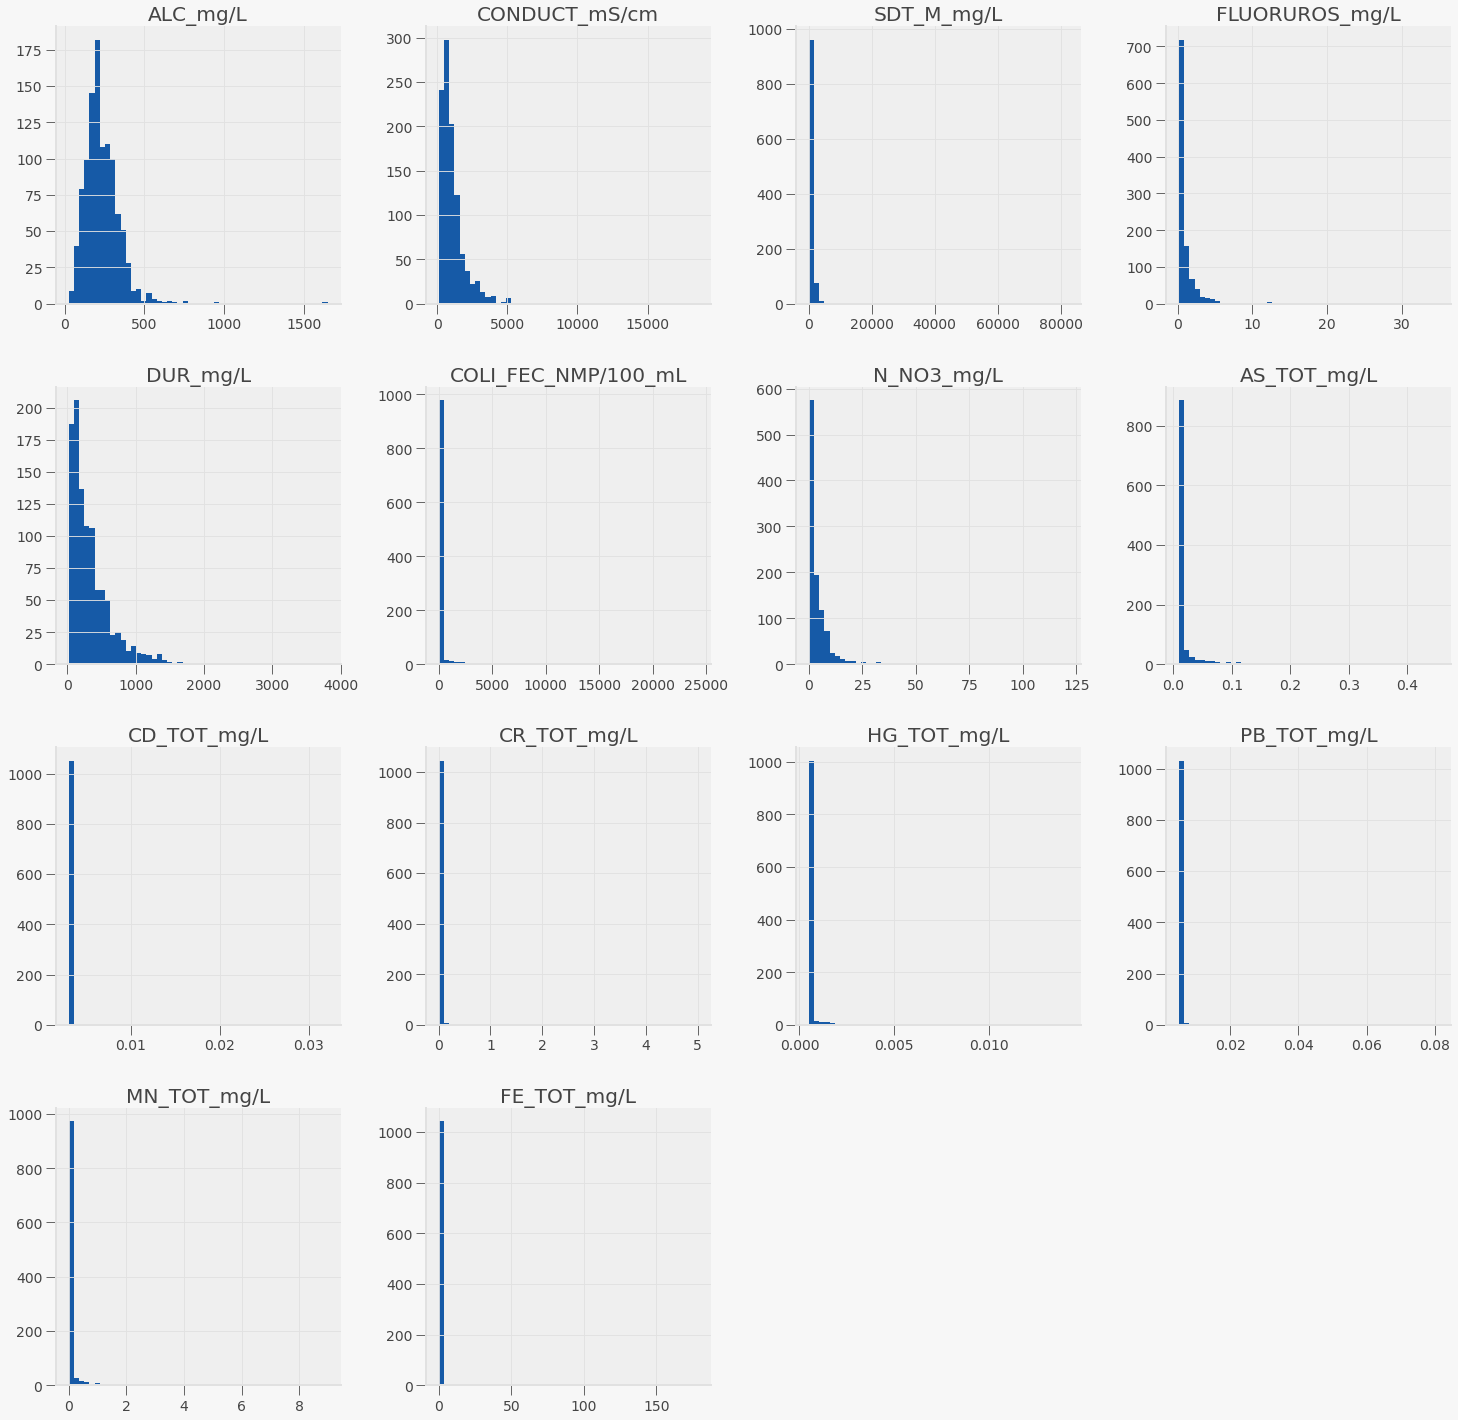

In [30]:
data[numericas].hist(bins = 50, figsize=(25,25))

Con la grafica, Conseguimos valores estadísticos como la media, el conteo, la desviación estándar, el valor mímimo, los cuartiles y valor maximo. Esto por cada una de las varibles del dataset.

**Graficamos los datos numéricos de entrada para visualizar los outliers**

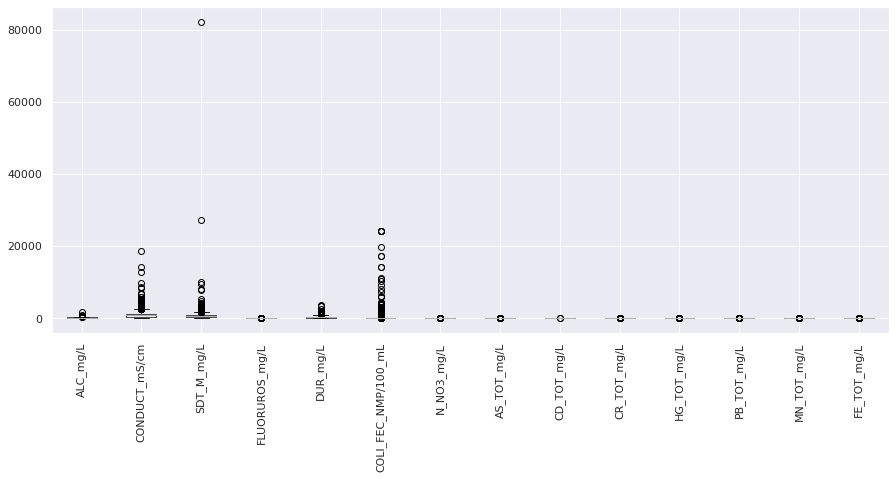

In [31]:
sns.set(rc={'figure.figsize':(15,6)})
data[numericas].boxplot(rot=90)

###**Identificamos los outliers**

In [32]:
Q1 = data[numericas].quantile(0.25)
Q3 = data[numericas].quantile(0.75)
IQR = Q3-Q1
BM = (data[numericas] > (Q3+1.5 *IQR)) | (data[numericas] < (Q1-1.5 *IQR))

**Vemos los valores de los outliers**

In [33]:
data[numericas][BM]

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0161,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0134,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0370,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0154,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,291.0,15.672251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,NaN,NaN,NaN,NaN,NaN,NaN,14.615488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1064,NaN,NaN,NaN,NaN,NaN,NaN,77.392000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1065,NaN,2600.0,1873.0,NaN,NaN,620.0,36.477104,NaN,NaN,NaN,NaN,NaN,0.0242,NaN
1066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Enviamos los outliers al upper cap [Q3+IQR*1.5]

In [34]:
for att in numericas:

    Q1 = data[att].quantile(0.25)
    Q3 = data[att].quantile(0.75)

    IQR = Q3 - Q1

    lower_cap = Q1-IQR*1.5
    upper_cap = Q3+IQR*1.5

    BM = data[att] < lower_cap

    candidate_index = data[BM].index
    data.loc[candidate_index,att] = lower_cap

    BM = data[att] > upper_cap

    candidate_index = data[BM].index

    data.loc[candidate_index,att] = upper_cap

Graficamos los resultados

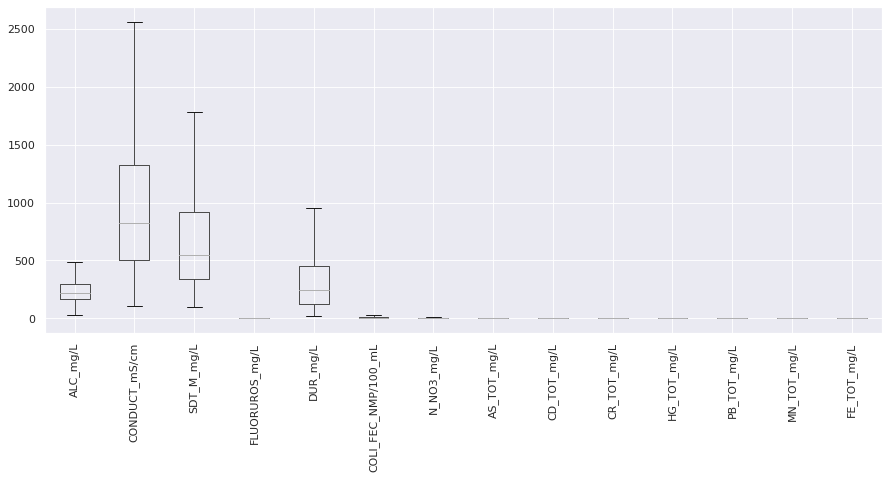

In [35]:
sns.set(rc={'figure.figsize':(15,6)})
data[numericas].boxplot(rot=90)

Escalamos los datos numericos de 0 a 1

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[numericas] = scaler.fit_transform(data[numericas])

Graficamos resultados despues de normalizar

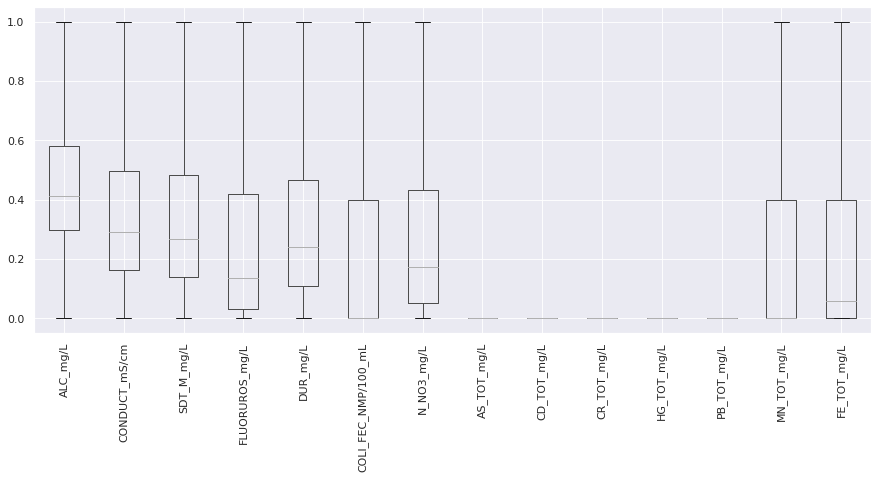

In [37]:
sns.set(rc={'figure.figsize':(15,6)})
data[numericas].boxplot(rot=90)

Corremos las gráficas de dispersión pero sin outliers

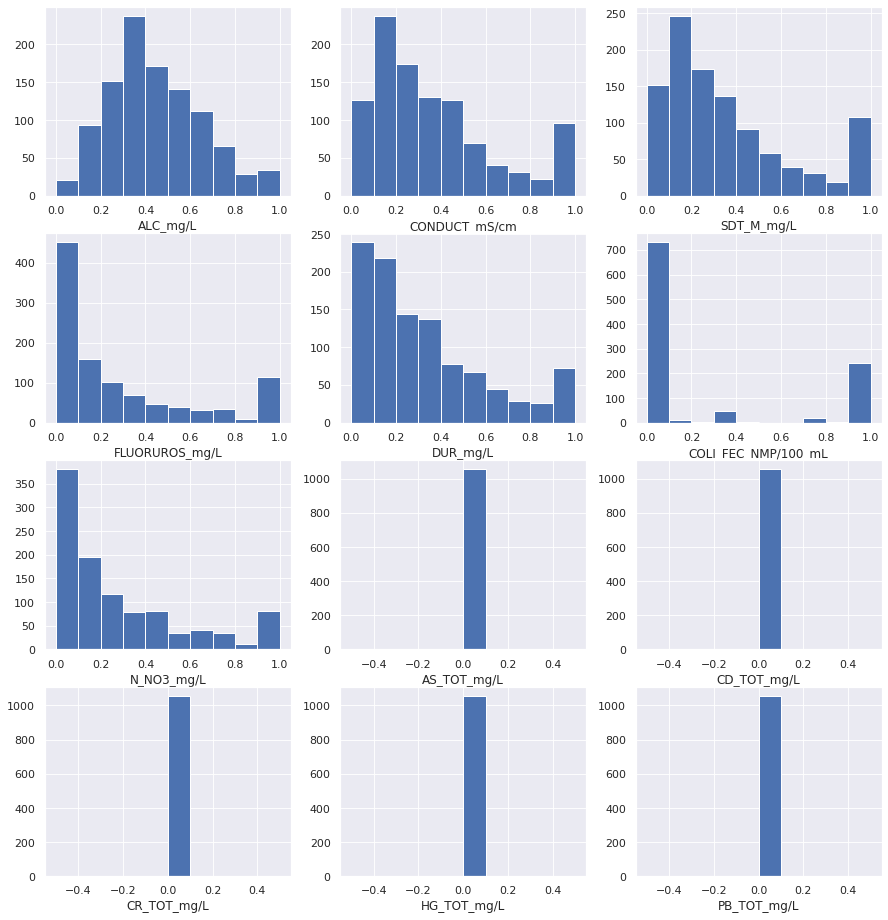

In [38]:
sns.set(rc={'figure.figsize':(15,16)})
fig, axes = plt.subplots(4, 3)    # Definimos una ventana de 5x4 nichos para incluir en cada uno de ellos un gráfico.
for k in range(0,12):
  plt.subplot(4,3,k+1)     # Los nichos para cada histograma se numeran iniciando en 1.
  plt.hist(data[data[numericas].columns[k]], bins=10)     # X_train.columns nos devuelve una lista con los nombres de las columnas.
  plt.xlabel(data[numericas].columns[k])
plt.show()

In [39]:
for k in variablesBool:
  data[k + ' BOOL'] = data[k].map({
    'SI': True,
    'NO': False,
  })  

In [40]:
data[[s + " BOOL" for s in variablesBool]]

,CUMPLE_CON_ALC BOOL,CUMPLE_CON_COND BOOL,CUMPLE_CON_SDT_ra BOOL,CUMPLE_CON_SDT_salin BOOL,CUMPLE_CON_FLUO BOOL,CUMPLE_CON_DUR BOOL,CUMPLE_CON_CF BOOL,CUMPLE_CON_NO3 BOOL,CUMPLE_CON_CD BOOL
0,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True
2,True,True,True,True,False,True,True,True,True
3,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...
1063,True,False,True,True,True,False,True,False,True
1064,True,True,True,True,True,True,True,False,True
1065,True,False,True,True,True,False,True,False,True
1066,True,True,True,True,True,True,True,True,True


Podemos observar que en general la calidad de agua en todo el pais se encuentra en semaforo naranja

In [41]:
media = data["SEMAFORO NUMERO"].mean()
mediana = data["SEMAFORO NUMERO"].median()
moda = data["SEMAFORO NUMERO"].mode()
print("Media:", media)
print("Mediana:", mediana)
print("Moda:", moda)

Media: 1.8273244781783682
Mediana: 2.0
Moda: 0    1
dtype: int64


In [42]:
std = data["SEMAFORO NUMERO"].std(ddof=0)
var = data["SEMAFORO NUMERO"].var(ddof=0)
rango = data["SEMAFORO NUMERO"].max() - data["SEMAFORO NUMERO"].min()
iqr = data["SEMAFORO NUMERO"].quantile(0.75) - data["SEMAFORO NUMERO"].quantile(0.25)
cv = data["SEMAFORO NUMERO"].std(ddof=0) / data["SEMAFORO NUMERO"].mean()

print("Desviacion estandar", std)
print("Varianza", var)
print("Coeficiente de variación", cv)

Desviacion estandar 0.7795859937549438
Varianza 0.6077543216588832
Coeficiente de variación 0.4266270183892579


Determinamos el agua es de calidad asegurandonos que cumple con todo lo solicitado

In [43]:
data["CALIDAD"] = data[[s + " BOOL" for s in variablesBool]].all(1)
data["CALIDAD"].unique()

array([ True, False])

Determinamos el Estado con mejor calidad de agua

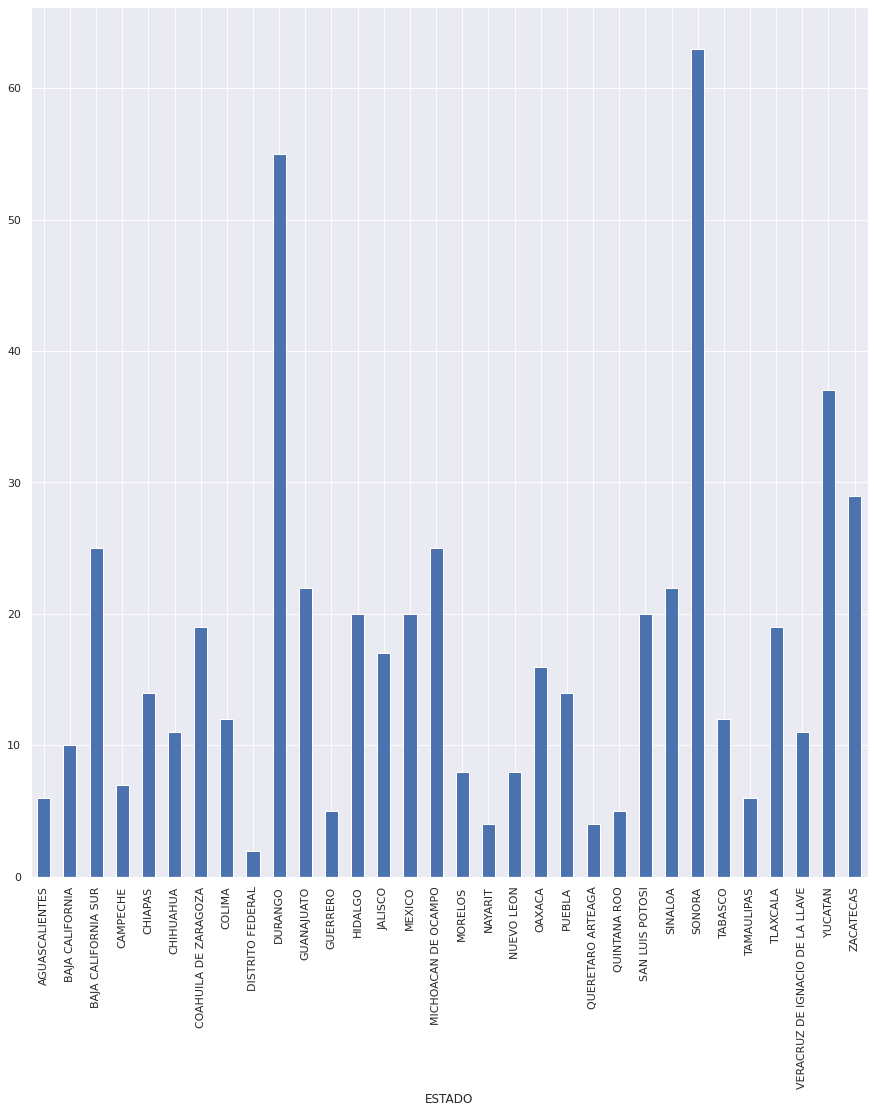

In [44]:
data.groupby(['ESTADO'])["CALIDAD"].sum().plot(kind='bar')

Mostramos la correlación entra longitud, latitud y los valores de cumplimiento de calidad del agua. Podemos determinar que no existe mucha correlación entre la ubicación y la calidad del agua.

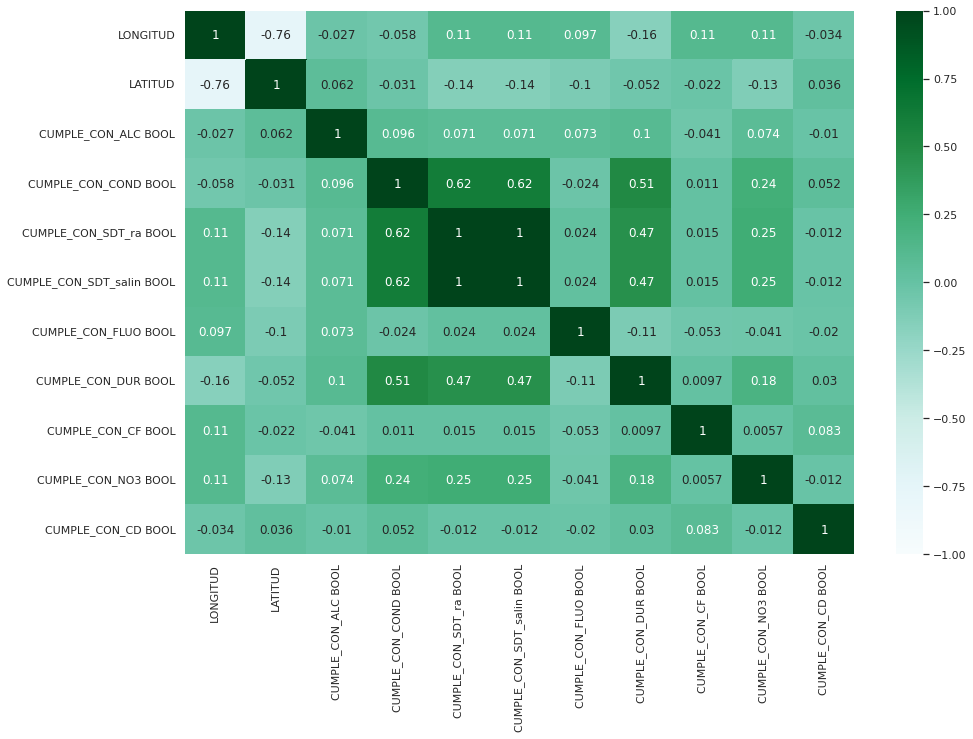

In [45]:
corrs = data[variables + [s + " BOOL" for s in variablesBool]].corr()
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corrs, vmin = -1, vmax = 1, cmap = "BuGn", annot= True)

Mostramos un mapa de la replica con cada pozo y su semaforo de calidad

In [46]:
data["Coordinates"] = list(zip(data["LONGITUD"], data["LATITUD"]))
data["Coordinates"] = data["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(data, geometry="Coordinates")

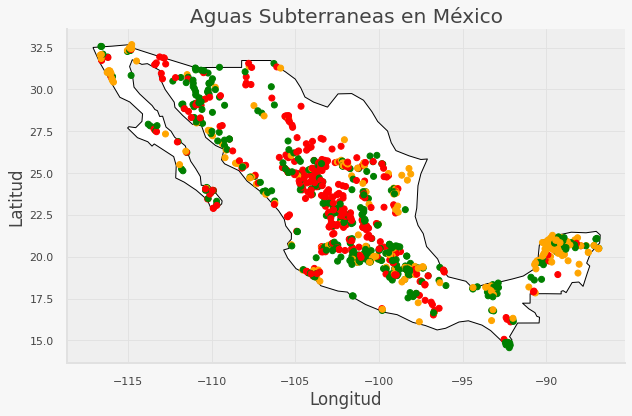

In [47]:
%matplotlib inline

import qeds
qeds.themes.mpl_style();

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

colors = {1:'green', 2:'red', 3:'orange'}

gdf.plot(ax=gax, c=data['SEMAFORO NUMERO'].map(colors), alpha = 1)

gax.set_xlabel('Longitud')
gax.set_ylabel('Latitud')
gax.set_title('Aguas Subterraneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Text(0, 0.5, 'WCSS')

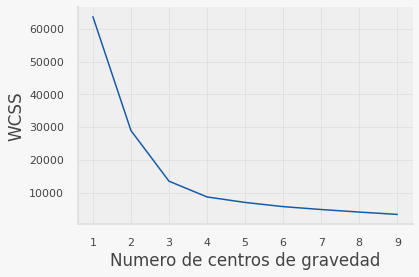

In [48]:
ldf = data[['LATITUD', 'LONGITUD', 'SEMAFORO NUMERO']]
wcss=[]
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(ldf)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.xlabel('Numero de centros de gravedad')
plt.ylabel('WCSS')

# Parte 1 - Clusters y centros de gravedad de acuerdo a la ubicación

In [49]:
gravityDF = pd.DataFrame(kmeans.cluster_centers_, columns = ['Latitude','Longitude', 'Semaforo'])

**Visualización de Kmeans**

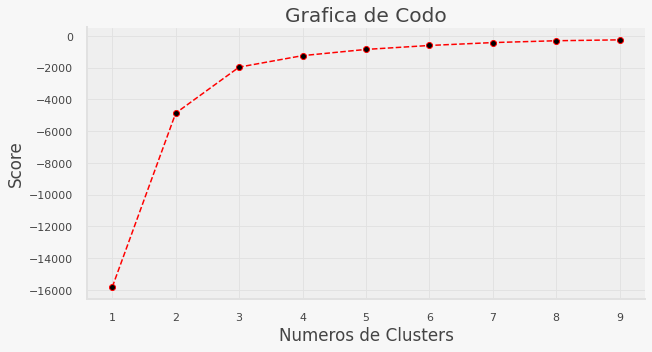

In [50]:
Cluster_nums = range(1,10) 
kmeans = [KMeans(n_clusters=i) for i in Cluster_nums]
Y_axis = data[['LATITUD']]
X_axis = data[['LONGITUD']]
kmean_calc = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.figure(figsize=(10,5))
plt.plot(Cluster_nums, kmean_calc,color='red', linestyle='dashed', marker='o',
    markerfacecolor='black')
plt.xlabel('Numeros de Clusters')
plt.ylabel('Score')
plt.title('Grafica de Codo')
plt.show()

In [51]:
kmeans = KMeans(4)
kmeans.fit(ldf)
identified_clusters = kmeans.fit_predict(ldf)
identified_clusters

array([1, 1, 3, ..., 3, 3, 3], dtype=int32)

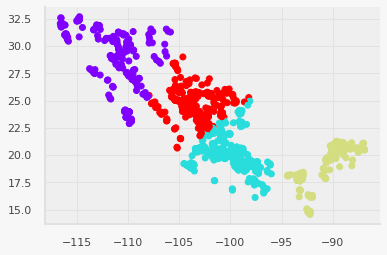

In [52]:
data_with_clusters = data.copy()
data_with_clusters['CLUSTERS'] = identified_clusters 
plt.scatter(data_with_clusters['LONGITUD'],data_with_clusters['LATITUD'],c=data_with_clusters['CLUSTERS'],cmap='rainbow')

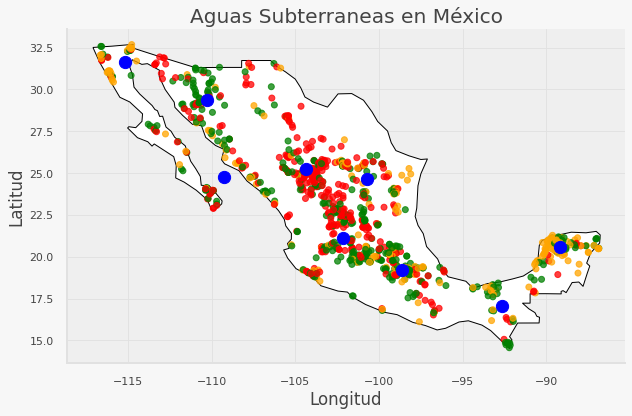

In [53]:
%matplotlib inline

import qeds
qeds.themes.mpl_style();

gravityDF["Coordinates"] = list(zip(gravityDF['Longitude'], gravityDF['Latitude']))
gravityDF["Coordinates"] = gravityDF["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(gravityDF, geometry="Coordinates")

gravityDF = gpd.GeoDataFrame(gravityDF, geometry="Coordinates")

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

colors = {1:'green', 2:'red', 3:'orange'}

gdf = gpd.GeoDataFrame(data, geometry="Coordinates")

gdf.plot(ax=gax, c=data['SEMAFORO NUMERO'].map(colors), alpha = .75)
gravityDF.plot(ax=gax, color='blue', alpha = 1, markersize=150)

gax.set_xlabel('Longitud')
gax.set_ylabel('Latitud')
gax.set_title('Aguas Subterraneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Visualizamos el conteo por semaforo en cada uno de los clusters

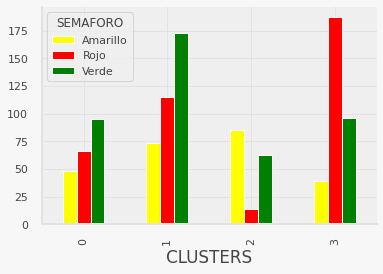

In [54]:
data_with_clusters_semaforo = data_with_clusters.groupby(['CLUSTERS', 'SEMAFORO']).size().unstack(fill_value=0)
data_with_clusters_semaforo.plot(kind='bar', color=['yellow', 'red', 'green'])

# Parte 2 - Centros de gravedad de acuerdo a la calidad del agua

In [55]:
redData = data[data['SEMAFORO'] == 'Rojo']
yellowData = data[data['SEMAFORO'] == 'Amarillo']
greenData = data[data['SEMAFORO'] == 'Verde']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


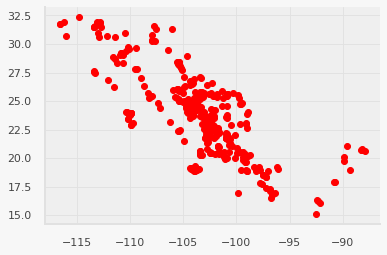

In [56]:
ldf = redData[['LATITUD', 'LONGITUD', 'SEMAFORO NUMERO']]
kmeansRed = KMeans(1)
kmeansRed.fit(ldf)
identified_clustersR = kmeansRed.fit_predict(ldf)
redData['CLUSTERS'] = identified_clustersR
plt.scatter(redData['LONGITUD'],redData['LATITUD'],color='red')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


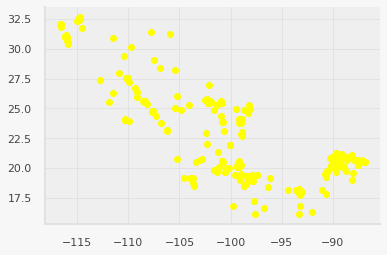

In [57]:
ldf = yellowData[['LATITUD', 'LONGITUD', 'SEMAFORO NUMERO']]
kmeansYellow = KMeans(1)
kmeansRed.fit(ldf)
identified_clustersY = kmeansYellow.fit_predict(ldf)
yellowData['CLUSTERS'] = identified_clustersY
plt.scatter(yellowData['LONGITUD'],yellowData['LATITUD'],color='yellow')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


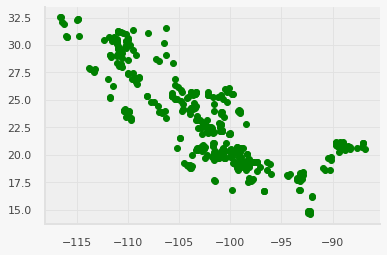

In [58]:
ldf = greenData[['LATITUD', 'LONGITUD', 'SEMAFORO NUMERO']]
kmeansGreen = KMeans(1)
kmeansGreen.fit(ldf)
identified_clustersG = kmeansGreen.fit_predict(ldf)
greenData['CLUSTERS'] = identified_clustersG
plt.scatter(greenData['LONGITUD'],greenData['LATITUD'],color='green')

In [59]:
gravityRed = pd.DataFrame(kmeansRed.cluster_centers_, columns = ['Latitude','Longitude', 'Semaforo'])
gravityYellow = pd.DataFrame(kmeansYellow.cluster_centers_, columns = ['Latitude','Longitude', 'Semaforo'])
gravityGreen = pd.DataFrame(kmeansGreen.cluster_centers_, columns = ['Latitude','Longitude', 'Semaforo'])

Mostramos en el mapa los tres centros de gravedad de cada segmento de calidad del agua

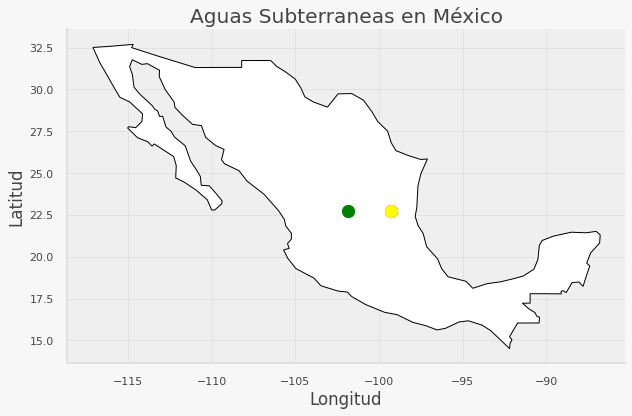

In [60]:
%matplotlib inline

import qeds
qeds.themes.mpl_style();

gravityRed["Coordinates"] = list(zip(gravityRed['Longitude'], gravityRed['Latitude']))
gravityRed["Coordinates"] = gravityRed["Coordinates"].apply(Point)
gdfR = gpd.GeoDataFrame(gravityRed, geometry="Coordinates")
gravityRed = gpd.GeoDataFrame(gravityRed, geometry="Coordinates")

gravityYellow["Coordinates"] = list(zip(gravityYellow['Longitude'], gravityYellow['Latitude']))
gravityYellow["Coordinates"] = gravityYellow["Coordinates"].apply(Point)
gdfY = gpd.GeoDataFrame(gravityYellow, geometry="Coordinates")
gravityYellow = gpd.GeoDataFrame(gravityYellow, geometry="Coordinates")

gravityGreen["Coordinates"] = list(zip(gravityGreen['Longitude'], gravityRed['Latitude']))
gravityGreen["Coordinates"] = gravityGreen["Coordinates"].apply(Point)
gdfG = gpd.GeoDataFrame(gravityGreen, geometry="Coordinates")
gravityGreen = gpd.GeoDataFrame(gravityGreen, geometry="Coordinates")

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

gravityRed.plot(ax=gax, color='red', alpha = 1, markersize=150)
gravityYellow.plot(ax=gax, color='yellow', alpha = 1, markersize=150)
gravityGreen.plot(ax=gax, color='green', alpha = 1, markersize=150)

gax.set_xlabel('Longitud')
gax.set_ylabel('Latitud')
gax.set_title('Aguas Subterraneas en México')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Podemos concluir que es muy util comprender este tipo de interacciónes que hay entre diferentes variables y de que forma se pueden usar para graficar o incluso, establecer su ubicación geografica.

Como en este caso analizando la ubicación geografica de los mantos acuiferos, determinar los clusters de la calidad del agua. Nos damos cuenta ahora que con K-means, acerca las ubicaciones geograficas por sus cercanías a los centroides, a diferencia de las ubicaciones identificadas con semaforos de contaminantes.

Con la grafica de codos, nos percatamos que al establecer 3 clusters aun estaría por abajo del rendimiento deseado, aun en el 4to cluster hay un crecimiento considerablemente importante.